# TextNow Take Home Test
- Time: August 23, 2017
- Author: Xiaonan Duan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load data and Some sanity check

In [2]:
trip = pd.read_csv('babs_open_data_year_2/201508_trip_data.csv')
# rename the trip's columns to a simplier names
trip.columns = [ 'ID', 'Duration','Start_date','Start_station',
                'Start_terminal','End_date','End_station','End_terminal',
                'Bike_no','Subscriber_Type','Zipcode']

In [3]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354152 entries, 0 to 354151
Data columns (total 11 columns):
ID                 354152 non-null int64
Duration           354152 non-null int64
Start_date         354152 non-null object
Start_station      354152 non-null object
Start_terminal     354152 non-null int64
End_date           354152 non-null object
End_station        354152 non-null object
End_terminal       354152 non-null int64
Bike_no            354152 non-null int64
Subscriber_Type    354152 non-null object
Zipcode            353874 non-null object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [5]:
# change Start_date, End_date to datetime type
# change Zipcode to int
trip['Start_date'] = pd.to_datetime(trip['Start_date'])
trip['End_date'] = pd.to_datetime(trip['End_date'])

In [18]:
trip['Start_date_new'] = pd.to_datetime(trip['Start_date']).dt.date
trip['End_date_new'] = pd.to_datetime(trip['End_date']).dt.date

In [6]:
# now the new data type
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354152 entries, 0 to 354151
Data columns (total 11 columns):
ID                 354152 non-null int64
Duration           354152 non-null int64
Start_date         354152 non-null datetime64[ns]
Start_station      354152 non-null object
Start_terminal     354152 non-null int64
End_date           354152 non-null datetime64[ns]
End_station        354152 non-null object
End_terminal       354152 non-null int64
Bike_no            354152 non-null int64
Subscriber_Type    354152 non-null object
Zipcode            353874 non-null object
dtypes: datetime64[ns](2), int64(5), object(4)
memory usage: 29.7+ MB


In [8]:
# are there duplicated records in the dataset?- No
trip.duplicated().sum()
# Are there missing data in the dataset? -some zipcode is missing
trip.isnull().sum()

ID                   0
Duration             0
Start_date           0
Start_station        0
Start_terminal       0
End_date             0
End_station          0
End_terminal         0
Bike_no              0
Subscriber_Type      0
Zipcode            278
dtype: int64

In [9]:
# take a look at the data
trip.head(3)

,ID,Duration,Start_date,Start_station,Start_terminal,End_date,End_station,End_terminal,Bike_no,Subscriber_Type,Zipcode
0,913460,765,2015-08-31 23:26:00,Harry Bridges Plaza (Ferry Building),50,2015-08-31 23:39:00,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139
1,913459,1036,2015-08-31 23:11:00,San Antonio Shopping Center,31,2015-08-31 23:28:00,Mountain View City Hall,27,35,Subscriber,95032
2,913455,307,2015-08-31 23:13:00,Post at Kearny,47,2015-08-31 23:18:00,2nd at South Park,64,468,Subscriber,94107


# Questions and Answers

** <font color='red'>- Q1: find the bike which is used most in the dataset(Sept 2014- Aug 2015) </font>**

** Answer: Bike # 878 (which is used 1121 times)**

 to get this, I will groupby on Bike_no (use value_counts here) to count the usage for each bike. Below is to get top 10 most used bike and Bike # 878 gets used most with 1121 times.

In [10]:
# to get the top 10 most used bike
trip.Bike_no.value_counts()[:10]

878    1121
392    1102
489    1101
463    1085
532    1074
558    1071
306    1060
29     1057
66     1053
589    1052
Name: Bike_no, dtype: int64

**  <font color='red'>- Q2: Are customers or subscribers more likely to make round trips? If using a hypothesis test, state assumption and give a p-value. If there is a significant difference, why do you think this might be the case? </font>**

Answer: there is a significant difference between customers and subscribers.
- t_score = diff/SE = 170.74
- The P-Value is < .00001

** <font color='red'> My explanation </font> ** : Results above indicate customers have much higher round trip probability than subscribers.  Customers who only use it for a short time(24-hour or 3-day member) are likely to be short-term visitors, so they tend to return on the same place. While Subscribers who have a membership are more likely to be citizens, so subscribers will use bikes as a commute for work, so they will not return on the same place. 

Logic and thoughts: We can use this data to do a A/B testing analysis. For this question, the metric to evaluate is the **probability of round trip(round trip rate) between customers(Pa) and subscribers(Pb).**


** Hypothesis test **

control: customers; 
treatment: subscribers

* ** $Ho(null\ hypothesis)$ **: 
 - There is no difference of round trip rate between customers and subscribers. 
 - difference = Pa - Pb = 0
* $Ha(alternative\ hypothesis)$:
 - difference = Pa - Pb != 0
 - There is a difference of round trip rate between these two groups.
 

**For this test: **  
- round trip rate of customer: 0.157; round trip rate of subscriber: 0.011
- size of customer: 43935; size of subscriber: 310217
- P_pool = (Na *  Pa + Nb * Pb)/(Na + Nb) = 0.029
- Standard Error(SE) =  $ (P(pool)* (1-P(pool)(1/Na + 1/Nb))^{0.5}$ = 0.00086

- diff = Pa - Pb

- t_score = diff/SE = 170.74
- The P-Value is < .00001

Definition of Subscription Type: Subscriber = annual or 30-day member; Customer = 24-hour or 3-day member

Detailed calculation as below

In [12]:
# add a new column to see if this is a round trip or not
# round trip means start_terminal = end_terminal
trip['round_trip'] = (trip['Start_terminal'] == trip['End_terminal'])

In [13]:
# first of all: get round trip rate for customers and subscribers. Also get size of each.

customer = trip[trip.Subscriber_Type == 'Customer']
subscriber = trip[trip.Subscriber_Type == 'Subscriber']

get the sample size for customers and subscribers

In [14]:
Na = customer.shape[0] # this is the number of people who are customers.
Nb = subscriber.shape[0] # this is the number of people who are subscribers.
print "size of customer: %d" %Na
print "size of subscriber: %d" %Nb

size of customer: 43935
size of subscriber: 310217


Get the round trip rate(probability of round trip for each group)

In [15]:
Pa = customer.round_trip.mean() # round trip rate for customer
Pb = subscriber.round_trip.mean() # round trip rate for subscriber

In [17]:
print "round trip rate of customer: %.3f" %Pa
print "round trip rate of subscribe: %.3f" %Pb

round trip rate of customer: 0.157
round trip rate of subscribe: 0.011


calculate P_pool 
P_pool = (Na *  Pa + Nb * Pb)/(Na + Nb)

In [19]:
P_pool = (Na * Pa + Nb * Pb)/(Na + Nb)
print "p_pool is : %.3f" % P_pool

p_pool is : 0.029


calucuate Standard Error

In [21]:
variance = P_pool*(1-P_pool)*(1.00/Na + 1.00/Nb)
SE = np.sqrt(variance)
print "standard Error is %.5f" % SE

standard Error is 0.00086


In [23]:
diff = Pa - Pb
t_score = diff/SE
print "t_score is %.2f" % t_score

t_score is 170.74


** The P-Value is < .00001. (assuming Significance Level: 0.05)
 This means that there is a significant difference of round trip rate between customer and subscribers. **

** <font color='red'> Q3: provide a graph of daily trips over entire period. </font> **

In [24]:
trip.head(2)

,ID,Duration,Start_date,Start_station,Start_terminal,End_date,End_station,End_terminal,Bike_no,Subscriber_Type,Zipcode,round_trip,Start_date_new,End_date_new
0,913460,765,2015-08-31 23:26:00,Harry Bridges Plaza (Ferry Building),50,2015-08-31 23:39:00,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139,False,2015-08-31,2015-08-31
1,913459,1036,2015-08-31 23:11:00,San Antonio Shopping Center,31,2015-08-31 23:28:00,Mountain View City Hall,27,35,Subscriber,95032,False,2015-08-31,2015-08-31


In [25]:
# how many trips that are not on the same day

not_same_day = (trip.Start_date_new != trip.End_date_new)
not_same_day.sum() 
#there are 920 trips that are not on the same day over 354,152. This is tiny portion.

920

group by start_date with number of trips 

In [28]:
group_start = trip.groupby('Start_date_new').size().reset_index()
group_start.columns = ['Start_date_new','trip_cnt']

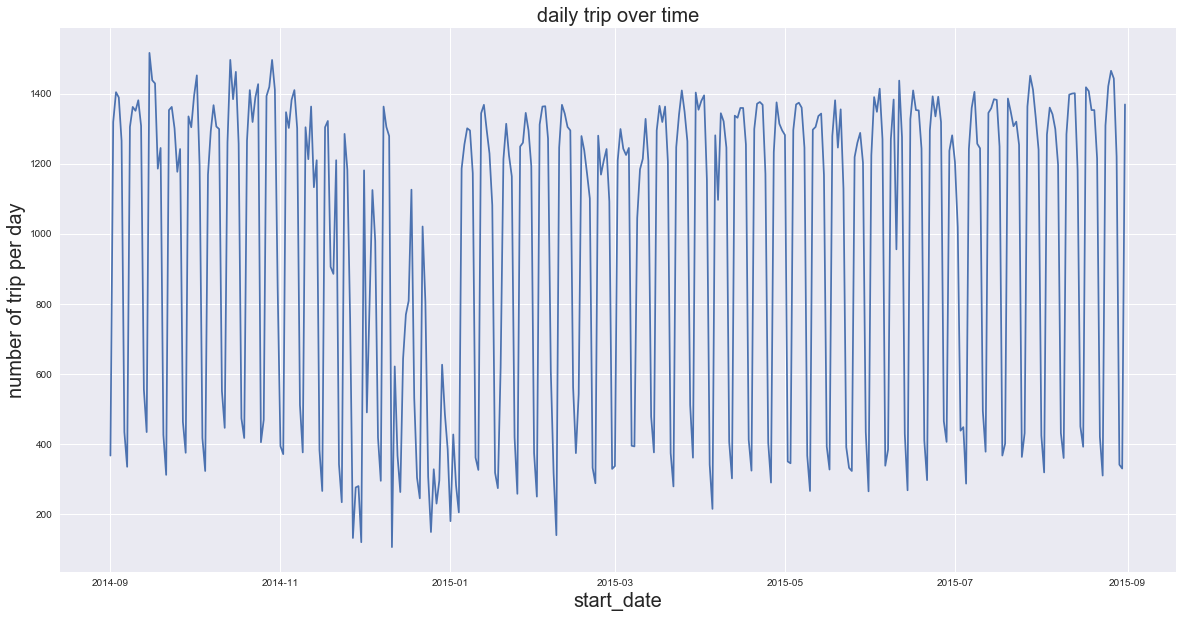

In [29]:
x = group_start.Start_date_new
y = group_start.trip_cnt

plt.figure(figsize=(20,10))
plt.plot(x, y)
plt.xlabel('start_date',fontsize = 20)
plt.ylabel('number of trip per day',fontsize = 20)
plt.title('daily trip over time', fontsize = 20)
plt.show()

Observations: we can see there are definitely some patterns with the usage over time on a weekly basis.

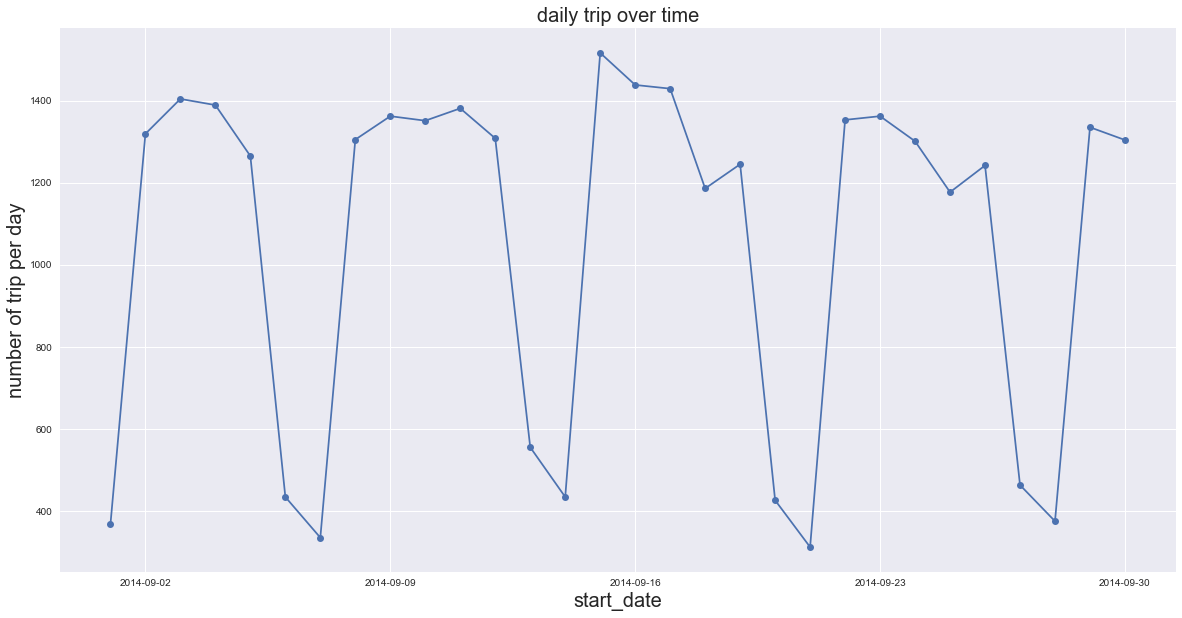

In [30]:
# plot a zoom in to see a short period of time
a = group_start.Start_date_new[:30]
b = group_start.trip_cnt[:30]

plt.figure(figsize=(20,10))
plt.plot(a, b, marker = 'o')
plt.xlabel('start_date',fontsize = 20)
plt.ylabel('number of trip per day',fontsize = 20)
plt.title('daily trip over time', fontsize = 20)
plt.show()

weekday pattern

In [57]:
group_start = trip.groupby('weekday').size().reset_index()
group_start.columns = ['weekday','trip_cnt']

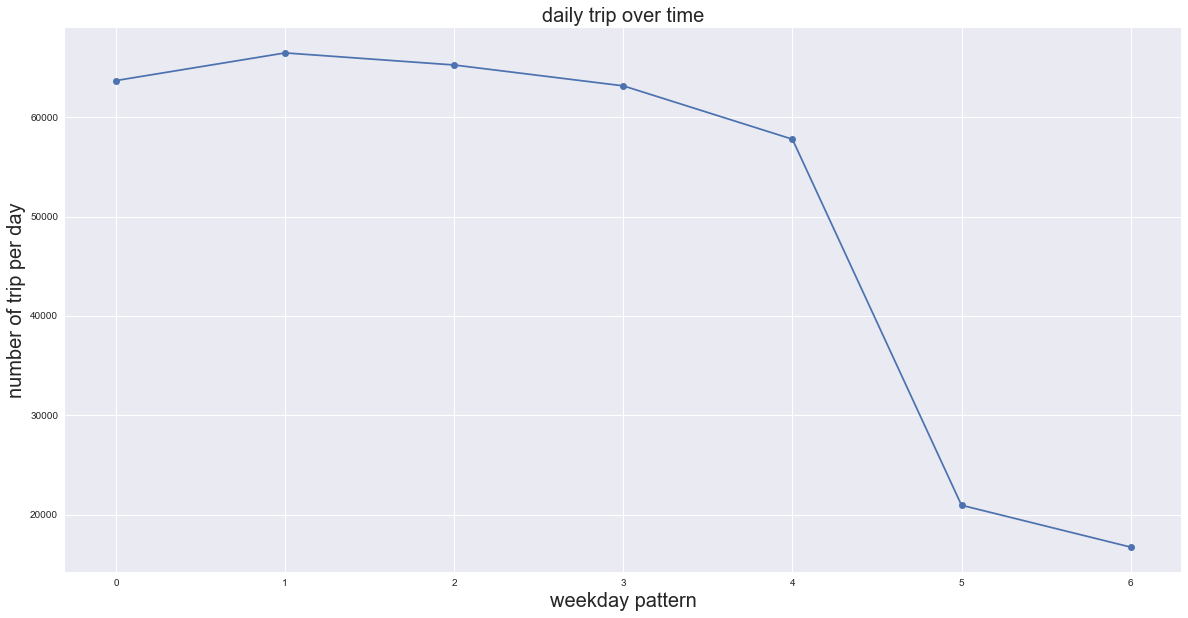

In [59]:
# plot a zoom in to see a short period of time
a = group_start.weekday[:30]
b = group_start.trip_cnt[:30]

plt.figure(figsize=(20,10))
plt.plot(a, b, marker = 'o')
plt.xlabel('weekday pattern',fontsize = 20)
plt.ylabel('number of trip per day',fontsize = 20)
plt.title('daily trip over time', fontsize = 20)
plt.show()

** <font color='red'> Q4: Are there usage pattern differences between weekdays and weekend trips?  </font> **

I will focus on duration and round trip rate between them.

make a new column to give days
weekday-- 0:Mon; 1:Tue...5:Saturday,6:Sunday

In [31]:
# weekday-- 0:Mon; 1:Tue...5:Saturday,6:Sunday
trip['weekday'] = trip['Start_date'].dt.weekday

In [36]:
def is_weekend(value):
    """
    to see if it is weekend or not
    """
    if type(value)!=int:
        return np.nan
    else:
        if value >=0 and value <= 4: # weekday
            return 0
        else:
            return 1

In [37]:
trip['is_weekend'] = trip['weekday'].apply(is_weekend) 

In [38]:
# get a summary
trip.is_weekend.value_counts()

0    316498
1     37654
Name: is_weekend, dtype: int64

89% of data are at weekdays, 11% are at weekends

In [39]:
trip.is_weekend.value_counts(normalize= True)

0    0.893678
1    0.106322
Name: is_weekend, dtype: float64

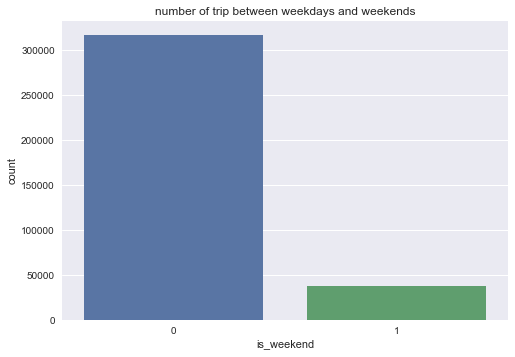

In [41]:
sns.countplot(data = trip, x = 'is_weekend')
plt.title('number of trip between weekdays and weekends')
plt.show()

In [ ]:
# let's see average duration of usage of bike between weekdays and weekends
duration_mean = trip.groupby('is_weekend')['Duration'].mean()

duration_std 

** Trip duration is different between weekdays and weekends: this could be that people are doing fun activities(sightseeings) at weekends so will use longer times. While weekdays are mainly for commute. **

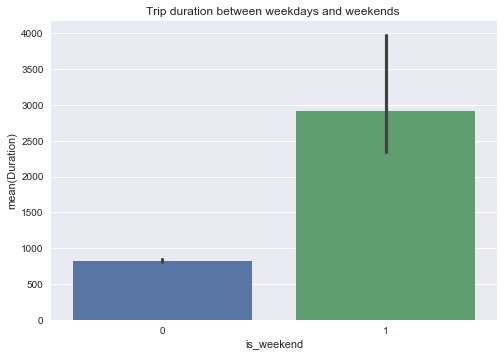

In [43]:
sns.barplot(data= trip, x = 'is_weekend'
           ,y = 'Duration')
plt.title('Trip duration between weekdays and weekends ')
plt.show()

** Round trip rate is different between weekdays and weekends: this could be that people are doing fun activities(sightseeings) at weekends so will be more likely to return on the same place. While weekdays are mainly for commute, so return in different terminals. **

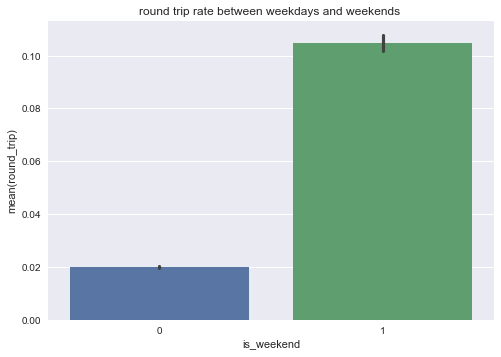

In [44]:
sns.barplot(data= trip, x = 'is_weekend'
           ,y = 'round_trip')
plt.title('round trip rate between weekdays and weekends ')
plt.show()

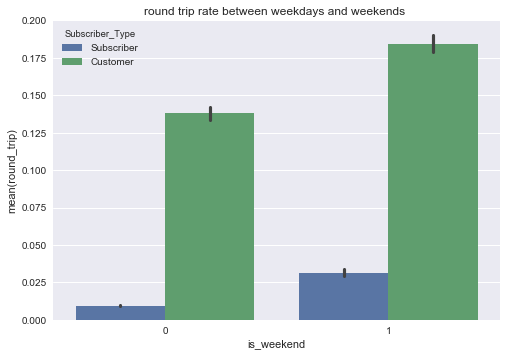

In [49]:
sns.barplot(data= trip, x = 'is_weekend'
           ,y = 'round_trip', hue = 'Subscriber_Type')
plt.title('round trip rate between weekdays and weekends ')
plt.show()

In [51]:
# the most popular terminal at weekdays
trip[trip.is_weekend == 0].Start_station.value_counts()[:5]

San Francisco Caltrain (Townsend at 4th)         25026
San Francisco Caltrain 2 (330 Townsend)          20583
Harry Bridges Plaza (Ferry Building)             14454
Temporary Transbay Terminal (Howard at Beale)    13894
Townsend at 7th                                  12802
Name: Start_station, dtype: int64

In [52]:
# the most popular terminal at weekend
trip[trip.is_weekend == 1].Start_station.value_counts()[:5]

Embarcadero at Sansome                  3048
Harry Bridges Plaza (Ferry Building)    2801
Market at 4th                           1533
Powell Street BART                      1509
2nd at Townsend                         1488
Name: Start_station, dtype: int64

** <font color='red'> Q5: what are the business ramification of your findings?</font> **

- Subscriber type: Subscriber = annual or 30-day member; Customer = 24-hour or 3-day member
  - customer and subscriber have very different use pattern: such as is_round_trip or not
- weekdays and weekends have different use pattern in terms of duration and round trip rate and popular location(terminals)
  - we should have different planning for theses.
- if I have more time, I will take a deeper look on the locations. For example, what are the number of bikes per start location? Are there differences in terms of weekends and weekdays? If there are, business can have different plans.


In [53]:
trip.head(2)

,ID,Duration,Start_date,Start_station,Start_terminal,End_date,End_station,End_terminal,Bike_no,Subscriber_Type,Zipcode,round_trip,Start_date_new,End_date_new,weekday,is_weekend
0,913460,765,2015-08-31 23:26:00,Harry Bridges Plaza (Ferry Building),50,2015-08-31 23:39:00,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139,False,2015-08-31,2015-08-31,0,0
1,913459,1036,2015-08-31 23:11:00,San Antonio Shopping Center,31,2015-08-31 23:28:00,Mountain View City Hall,27,35,Subscriber,95032,False,2015-08-31,2015-08-31,0,0


In [54]:
group_start = trip.groupby('weekday').size().reset_index()
group_start.columns = ['weekday','trip_cnt']

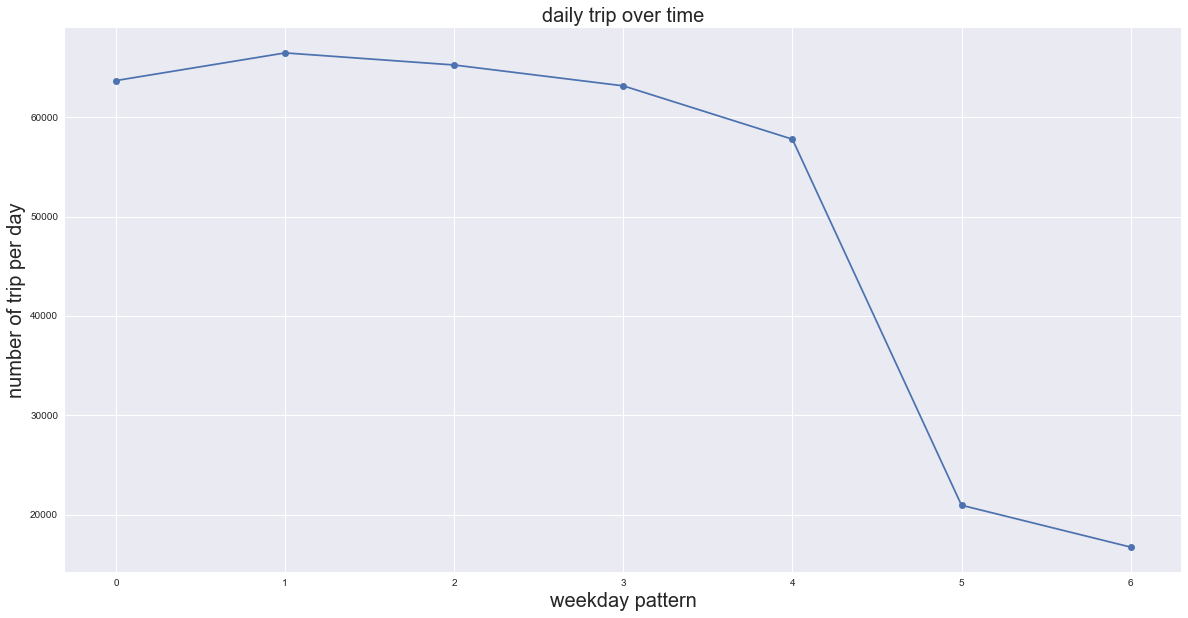

In [60]:
# plot a zoom in to see a short period of time
a = group_start.weekday[:30]
b = group_start.trip_cnt[:30]

plt.figure(figsize=(20,10))
plt.plot(a, b, marker = 'o')
plt.xlabel('weekday pattern',fontsize = 20)
plt.ylabel('number of trip per day',fontsize = 20)
plt.title('daily trip over time', fontsize = 20)
plt.show()